# IMPORTING THE NECESSARY LIBRARIES


In [ ]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from numpy import random
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn.tree import DecisionTreeClassifier

In [ ]:
# RNC
from sklearn.model_selection import KFold
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.optimizers import SGD

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Reading the data files to be classified
For this lab session, we will read the data from a CSV file.

In [ ]:
# data
X = np.genfromtxt('/content/drive/MyDrive/Colab Notebooks/TP1_IARN/data.csv', delimiter=',', dtype=int)
X.shape

(5000, 400)

In [ ]:
# labels
Y = np.genfromtxt('/content/drive/MyDrive/Colab Notebooks/TP1_IARN/labels.csv', delimiter=',', dtype=int)
Y.shape

(5000,)

Show a random sample of data from our dataset.

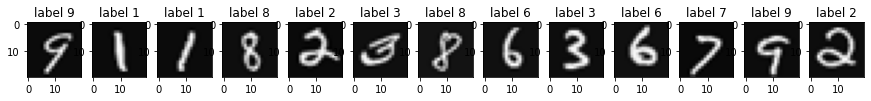

In [ ]:
plt.figure(figsize=(15,8))
for i in range(13):
    c = random.randint(X.shape[0]) #pich a random line from the dataset
    a = X[c,:].reshape((20, 20)) #shape of one number in the image
    a=np.transpose(a) # Transpose (swap rows and columns).
    plt.subplot(1,13,i+1)
    plt.title('label '+ str(Y[c]))
    plt.imshow(a,cmap='gray')

# Implementation of the requested metrics
Here, it's necessary to write the functions and then call them in the rest of the code.

- Confusion Matrix :

In [ ]:
# Confusion matrix --> Displays classification errors.
def matrice_confusion(observee, predite):
  # np.unique : This function returns an array of unique elements in the input array.
  nbr_classe = np.unique(observee).shape[0] # nombre of classes
  mat_confusion =  np.zeros((nbr_classe, nbr_classe), dtype=np.uint8) # Initialize the confusion matrix.
  for i in range(observee.shape[0]):
    mat_confusion[observee[i], predite[i]] = mat_confusion[observee[i], predite[i]] + 1
  return mat_confusion

Calculate the values of FP, TP, TN, FN in the confusion matrix.




In [ ]:
# Function that returns the values of FP, TP, TN, FN from the confusion matrix.
def valeurs_matrice_confusion(mat_confusion, id_classe):
  VP = mat_confusion[id_classe, id_classe]
  FP = np.sum(mat_confusion, axis=0)[id_classe] - VP
  FN = np.sum(mat_confusion, axis = 1)[id_classe] - VP
  VN = np.sum(mat_confusion) - VP - FP - FN
  return {"VP" : VP, "FP" : FP, "VN" : VN, "FN" : FN}

- Racall :

In [ ]:
def rappel(mat_confusion, id_classe):
  dict_metriques = valeurs_matrice_confusion(mat_confusion, id_classe)
  VP = dict_metriques["VP"]
  FN = dict_metriques["FN"]
  return VP/(VP + FN)

- Precision

In [ ]:
def precision(mat_confusion, id_classe):
  dict_metriques = valeurs_matrice_confusion(mat_confusion, id_classe)
  VP = dict_metriques["VP"]
  FP = dict_metriques["FP"]
  return VP/(VP + FP)

- False Positive Rate

In [ ]:
def Taux_FP(mat_confusion, id_classe):
  dict_metriques = valeurs_matrice_confusion(mat_confusion, id_classe)
  VP = dict_metriques["VP"]
  FP = dict_metriques["FP"]
  return FP/(FP + VP)

- Specificity

In [ ]:
def specificite(mat_confusion, id_classe):
  dict_metriques = valeurs_matrice_confusion(mat_confusion, id_classe)
  VN = dict_metriques["VN"]
  FP = dict_metriques["FP"]
  return VN/(VN + FP)

- ROC Curve

In [ ]:
def courbe_ROC(id_classe, observee, probabilities, couleur):
  cpy_observee = np.copy(observee)
  cpy_probabilities = np.copy(probabilities[:,id_classe])
  # Define a threshold vector.
  seuils = np.arange(0, 1.2, 0.2)
  # Initialize the two vectors vect_TPR and vect_FPR.
  vect_TPR = np.zeros(len(seuils))
  vect_FPR = np.zeros(len(seuils))
  # Transition from Multiclass Classification to Binary Classification (Modification of the Observed Target Vector cpy_observee).
  for i in range(len(cpy_observee)):
    if(cpy_observee[i]== id_classe):
      cpy_observee[i] = 1
    else :
      cpy_observee[i] = 0
  # Calculate the confusion matrix for each threshold value.
  for i in range(len(seuils)):
    cpy_predite = np.greater_equal(cpy_probabilities, seuils[i]).astype('uint8')
    mat_conf = np.copy(matrice_confusion(cpy_observee, cpy_predite))
    # Calculate sensitivity (True Positive Rates) and 1-Specificity (False Positive Rates).
    vect_TPR[i] = rappel(mat_conf, 0)
    vect_FPR[i] = 1 - specificite(mat_conf, 0)
  plt.plot(vect_FPR, vect_TPR, color=couleur, lw=2, marker='+', markersize=5, label='classe {0}'.format(id_classe))


# Classification

First, define the training dataset Xt, Yt, and the test dataset Xtt, Ytt.

In [ ]:
tRatio=2/3
ttRatio=1/3
Xt, Xtt, Yt, Ytt = train_test_split(X, Y, random_state=0, test_size=1/3)
print('Train set', Xt.shape)
print('Test set', Xtt.shape)

Train set (3333, 400)
Test set (1667, 400)


#Method 0 : K-Nearest Neighbors

Here, you will need to implement the method, then test it and verify the metrics by varying the value of K.

In [ ]:
# Function that calculates the Euclidean distance between two vectors of the same size.
def distance_euclidienne(vect1, vect2):
  sum = 0
  for i in range(len(vect1)):
    sum = sum + np.square(vect1[i]-vect2[i])
  return np.sqrt(sum)

# Function that returns the k nearest neighbors.
def get_voisins(x, X, k):
  voisins = []
  for i in range(len(X)):
    dist = distance_euclidienne(X[i], x)
    voisins.append((i, dist))
  # Sort the distances vector in ascending order of Euclidean distances.
  voisins.sort(key=lambda elt: elt[1])
  # Return the k nearest neighbors.
  return voisins[0:k]

# Function that predicts the class of our data point x.
def KPP(x,X, Y, k):
  # Create the occurrence vector for each class.
  vect_classes = np.zeros(len(np.unique(Y)))
  KPP_voisins = get_voisins(x, X, k)
  for i in range(len(KPP_voisins)):
    indice = KPP_voisins[i][0]
    vect_classes[Y[indice]]= vect_classes[Y[indice]] + 1
  id_classe = np.argmax(vect_classes)
  # Return the index of the maximum.
  return id_classe


# Testing implemented functions for the KNN algorithm and comparison with sklearn's functions.



*   **Confusion Matrix**



In [ ]:
from sklearn.neighbors import KNeighborsClassifier

#Initialize the model.
model = KNeighborsClassifier(n_neighbors=6)
# Train the model on Xt and Yt.
model.fit(Xt, Yt)
# Test the model on Xtt.
Y_predit = model.predict(Xtt)

# Calculation of y_pred.
# Y_predit = np.zeros(len(Ytt))
# for i in range(len(Xtt)):
#   # k = 6
#   Y_predit[i] = KPP(Xtt[i, :],Xt, Yt, 6)
MatConfusionScatch = matrice_confusion(Ytt, Y_predit)
print(MatConfusionScatch)

[[151   1   0   0   0   0   0   0   0   0]
 [  0 162   1   0   1   0   0   0   0   0]
 [  2   7 148   1   0   0   1   3   1   0]
 [  0   0   4 162   0   1   0   2   0   1]
 [  0   5   0   0 145   0   2   0   0   5]
 [  1   0   0   5   1 171   1   0   0   3]
 [  1   2   0   0   0   3 156   0   0   0]
 [  0   7   0   0   1   0   0 157   0   4]
 [  2   0   0   5   1   5   2   0 166   5]
 [  1   2   1   2   4   0   2   5   0 145]]




*   **Confusion Matrix with Sklearn**



In [ ]:
#Importing modules (KNeighborsClassifier, confusion_matrix) from the sklearn library.
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix

#Initialize the model.
model = KNeighborsClassifier(n_neighbors=6)
# Train the model on the training data Xt and Yt.
model.fit(Xt, Yt)
# Use the model on Xtt.
Y_preditSklearn = model.predict(Xtt)
# Calculation of the confusion matrix.
MatConfusionSklearn = confusion_matrix(Ytt, Y_preditSklearn)
print(MatConfusionSklearn)

[[151   1   0   0   0   0   0   0   0   0]
 [  0 162   1   0   1   0   0   0   0   0]
 [  2   7 148   1   0   0   1   3   1   0]
 [  0   0   4 162   0   1   0   2   0   1]
 [  0   5   0   0 145   0   2   0   0   5]
 [  1   0   0   5   1 171   1   0   0   3]
 [  1   2   0   0   0   3 156   0   0   0]
 [  0   7   0   0   1   0   0 157   0   4]
 [  2   0   0   5   1   5   2   0 166   5]
 [  1   2   1   2   4   0   2   5   0 145]]



*   **FP, VP, VN, FN**





In [ ]:
# Calculate the values of FP (False Positives), TP (True Positives), TN (True Negatives), and FN (False Negatives) for all classes of Ytt.
for i in range(10):
  dictScratch  = valeurs_matrice_confusion(MatConfusionScatch, i)
  # displaying the results
  print("FP classe "+str(i)+" est : "+str(dictScratch["FP"]))
  print("VP classe "+str(i)+" est : "+str(dictScratch["VP"]))
  print("VN classe "+str(i)+" est : "+str(dictScratch["VN"]))
  print("FN classe "+str(i)+" est : "+str(dictScratch["FN"]))
  print("------------------------------------------------------------------------------------------------------")


FP classe 0 est : 7
VP classe 0 est : 151
VN classe 0 est : 1508
FN classe 0 est : 1
------------------------------------------------------------------------------------------------------
FP classe 1 est : 24
VP classe 1 est : 162
VN classe 1 est : 1479
FN classe 1 est : 2
------------------------------------------------------------------------------------------------------
FP classe 2 est : 6
VP classe 2 est : 148
VN classe 2 est : 1498
FN classe 2 est : 15
------------------------------------------------------------------------------------------------------
FP classe 3 est : 13
VP classe 3 est : 162
VN classe 3 est : 1484
FN classe 3 est : 8
------------------------------------------------------------------------------------------------------
FP classe 4 est : 8
VP classe 4 est : 145
VN classe 4 est : 1502
FN classe 4 est : 12
------------------------------------------------------------------------------------------------------
FP classe 5 est : 9
VP classe 5 est : 171
VN classe 5 es

*   **Recall**



In [ ]:
# Calculate the recall value for all classes of Ytt.
for i in range(10):
  print("rappel classe "+str(i)+" = "+str(rappel(MatConfusionScatch, i)))
  print("------------------------------------------------------------------------------------------------------")


rappel classe 0 = 0.993421052631579
------------------------------------------------------------------------------------------------------
rappel classe 1 = 0.9878048780487805
------------------------------------------------------------------------------------------------------
rappel classe 2 = 0.9079754601226994
------------------------------------------------------------------------------------------------------
rappel classe 3 = 0.9529411764705882
------------------------------------------------------------------------------------------------------
rappel classe 4 = 0.9235668789808917
------------------------------------------------------------------------------------------------------
rappel classe 5 = 0.9395604395604396
------------------------------------------------------------------------------------------------------
rappel classe 6 = 0.9629629629629629
------------------------------------------------------------------------------------------------------
rappel classe 7 = 0.9

*   **Recall with sklearn**

In [ ]:
# Recall
from sklearn import metrics
print(metrics.recall_score(Ytt, Y_preditSklearn, average=None))

[0.99342105 0.98780488 0.90797546 0.95294118 0.92356688 0.93956044
 0.96296296 0.92899408 0.89247312 0.89506173]


*   **Precision**



In [ ]:
# Calculate the precision for all classes of Ytt.
for i in range(10):
  print("précision classe "+str(i)+" = "+str(precision(MatConfusionScatch, i)))
  print("------------------------------------------------------------------------------------------------------")

précision classe 0 = 0.9556962025316456
------------------------------------------------------------------------------------------------------
précision classe 1 = 0.8709677419354839
------------------------------------------------------------------------------------------------------
précision classe 2 = 0.961038961038961
------------------------------------------------------------------------------------------------------
précision classe 3 = 0.9257142857142857
------------------------------------------------------------------------------------------------------
précision classe 4 = 0.9477124183006536
------------------------------------------------------------------------------------------------------
précision classe 5 = 0.95
------------------------------------------------------------------------------------------------------
précision classe 6 = 0.9512195121951219
------------------------------------------------------------------------------------------------------
précision clas



*   **precision with sklearn**



In [ ]:
# précision(precision)
print(metrics.precision_score(Ytt, Y_preditSklearn, average=None))

[0.9556962  0.87096774 0.96103896 0.92571429 0.94771242 0.95
 0.95121951 0.94011976 0.99401198 0.88957055]


*   **False positive rate**



In [ ]:
# Calculate the False Positive Rate (FPR) for all classes of Ytt.
for i in range(10):
  print("Taux de FP classe "+str(i)+" = "+str(Taux_FP(MatConfusionScatch, i)))
  print("------------------------------------------------------------------------------------------------------")

Taux de FP classe 0 = 0.04430379746835443
------------------------------------------------------------------------------------------------------
Taux de FP classe 1 = 0.12903225806451613
------------------------------------------------------------------------------------------------------
Taux de FP classe 2 = 0.03896103896103896
------------------------------------------------------------------------------------------------------
Taux de FP classe 3 = 0.07428571428571429
------------------------------------------------------------------------------------------------------
Taux de FP classe 4 = 0.05228758169934641
------------------------------------------------------------------------------------------------------
Taux de FP classe 5 = 0.05
------------------------------------------------------------------------------------------------------
Taux de FP classe 6 = 0.04878048780487805
------------------------------------------------------------------------------------------------------




*   **Specificity**



In [ ]:
# Calculate the specificity for all classes of Ytt.
for i in range(10):
  print("spécificité classe "+str(i)+" = "+str(specificite(MatConfusionScatch, i)))
  print("------------------------------------------------------------------------------------------------------")


spécificité classe 0 = 0.9953795379537954
------------------------------------------------------------------------------------------------------
spécificité classe 1 = 0.9840319361277445
------------------------------------------------------------------------------------------------------
spécificité classe 2 = 0.9960106382978723
------------------------------------------------------------------------------------------------------
spécificité classe 3 = 0.991315965263861
------------------------------------------------------------------------------------------------------
spécificité classe 4 = 0.9947019867549669
------------------------------------------------------------------------------------------------------
spécificité classe 5 = 0.9939393939393939
------------------------------------------------------------------------------------------------------
spécificité classe 6 = 0.9946843853820598
-----------------------------------------------------------------------------------------



*   **ROC curve**



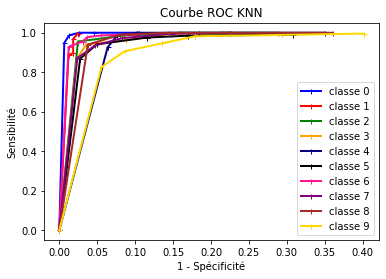

In [ ]:
# Calculation of the probability vector.
probabilities = model.predict_proba(Xtt)
# Define the color palette (for plotting).
colors = ['blue', 'red', 'green', 'orange', 'navy', 'black', 'deeppink', 'purple', 'brown', 'gold']
# afficher les 10 courbes ROC
for i in range(10):
  courbe_ROC(i, Ytt, probabilities, colors[i])
plt.title('Courbe ROC KNN')
plt.xlabel('1 - Spécificité')
plt.ylabel('Sensibilité')
plt.legend(loc="lower right")
plt.show()

*   **Roc curve with sklearn**

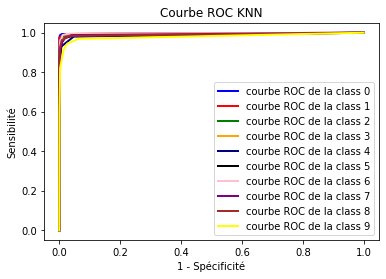

In [ ]:
# Import the modules (roc_curve, label_binarize, OneVsRestClassifier)
from sklearn.metrics import roc_curve
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier

# Binarize Ytt (labels)
Y_binaire = label_binarize(Y, classes=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
# Number of classes
nbr_classes = np.unique(Y.shape[0])

Xt, Xtt, Yt, Ytt = train_test_split(X, Y_binaire, random_state=0, test_size=1/3)
model = OneVsRestClassifier(KNeighborsClassifier(n_neighbors=6))
model.fit(Xt, Yt)


Yttproba = model.predict_proba(Xtt)
fpr = dict()
tpr = dict()
# Calculate FPR (False Positive Rate) and TPR (True Positive Rate)
for i in range(10):
  fpr[i], tpr[i],_ = roc_curve(Ytt[:, i], Yttproba[:, i])

colors = ['blue', 'red', 'green', 'orange', 'navy', 'black', 'pink', 'purple', 'brown', 'yellow']
for i in range(10):
    plt.plot(fpr[i], tpr[i], color=colors[i], linewidth=2, label='courbe ROC de la class {0}'.format(i))


# Plot the ROC curve
plt.title('Courbe ROC KNN')
plt.xlabel('1 - Spécificité')
plt.ylabel('Sensibilité')
plt.legend(loc="lower right")
plt.show()

# Method 1 : SVM
Support Vector Machine

In [ ]:
Xt, Xtt, Yt, Ytt = train_test_split(X, Y, random_state=0, test_size=1/3)
print('Train set', Xt.shape)
print('Test set', Xtt.shape)
#Create the model
model= svm.SVC(kernel='linear', probability=True)
# training
model.fit(Xt, Yt)
# Prediction
y_pred = model.predict(Xtt)

Train set (3333, 400)
Test set (1667, 400)


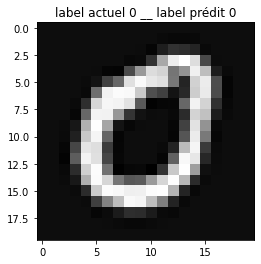

In [ ]:
# test for one image
c= 20
y_pred[c]
a = Xtt[c,:].reshape((20, 20))
a=np.transpose(a)
plt.title('label actuel '+ str(Ytt[c])+' __ label prédit '+ str(y_pred[c]))
plt.imshow(a,cmap='gray')

#Testing of implemented functions for the MVS algorithm and comparison with those from sklearn.



*   **Confusion Matrix**



In [ ]:
# Calculation of the confusion matrix
matrice_confusion(Ytt,y_pred)

array([[150,   0,   0,   0,   0,   1,   1,   0,   0,   0],
       [  0, 160,   0,   1,   0,   1,   0,   0,   2,   0],
       [  1,   1, 151,   0,   2,   0,   0,   3,   5,   0],
       [  0,   0,   5, 154,   0,   3,   0,   2,   5,   1],
       [  0,   2,   3,   1, 145,   1,   1,   1,   1,   2],
       [  1,   1,   2,  10,   0, 165,   0,   0,   3,   0],
       [  1,   1,   3,   0,   2,   6, 148,   0,   1,   0],
       [  0,   1,   5,   1,   3,   0,   0, 156,   0,   3],
       [  0,   2,   5,  10,   0,   8,   0,   0, 157,   4],
       [  2,   1,   1,   1,   7,   1,   0,  12,   2, 135]], dtype=uint8)



*   **Confusion Matrix with sklearn**



In [ ]:
confusion_matrix(Ytt, y_pred)

array([[150,   0,   0,   0,   0,   1,   1,   0,   0,   0],
       [  0, 160,   0,   1,   0,   1,   0,   0,   2,   0],
       [  1,   1, 151,   0,   2,   0,   0,   3,   5,   0],
       [  0,   0,   5, 154,   0,   3,   0,   2,   5,   1],
       [  0,   2,   3,   1, 145,   1,   1,   1,   1,   2],
       [  1,   1,   2,  10,   0, 165,   0,   0,   3,   0],
       [  1,   1,   3,   0,   2,   6, 148,   0,   1,   0],
       [  0,   1,   5,   1,   3,   0,   0, 156,   0,   3],
       [  0,   2,   5,  10,   0,   8,   0,   0, 157,   4],
       [  2,   1,   1,   1,   7,   1,   0,  12,   2, 135]])

*   **FP, VP, VN, FN**

In [ ]:
# Calculate values of FP, TP, TN, FN for all classes of Ytt.
for i in range(10):
  dictScratch  = valeurs_matrice_confusion(matrice_confusion(Ytt,y_pred), i)
  # displaying the results
  print("FP classe "+str(i)+" est : "+str(dictScratch["FP"]))
  print("VP classe "+str(i)+" est : "+str(dictScratch["VP"]))
  print("VN classe "+str(i)+" est : "+str(dictScratch["VN"]))
  print("FN classe "+str(i)+" est : "+str(dictScratch["FN"]))
  print("------------------------------------------------------------------------------------------------------")


FP classe 0 est : 5
VP classe 0 est : 150
VN classe 0 est : 1510
FN classe 0 est : 2
------------------------------------------------------------------------------------------------------
FP classe 1 est : 9
VP classe 1 est : 160
VN classe 1 est : 1494
FN classe 1 est : 4
------------------------------------------------------------------------------------------------------
FP classe 2 est : 24
VP classe 2 est : 151
VN classe 2 est : 1480
FN classe 2 est : 12
------------------------------------------------------------------------------------------------------
FP classe 3 est : 24
VP classe 3 est : 154
VN classe 3 est : 1473
FN classe 3 est : 16
------------------------------------------------------------------------------------------------------
FP classe 4 est : 14
VP classe 4 est : 145
VN classe 4 est : 1496
FN classe 4 est : 12
------------------------------------------------------------------------------------------------------
FP classe 5 est : 21
VP classe 5 est : 165
VN classe 5



*   **Recall**



In [ ]:
# Calculate the recall value for all classes of Ytt.
for i in range(10):
  print("rappel classe "+str(i)+" = "+str(rappel(matrice_confusion(Ytt,y_pred), i)))
  print("------------------------------------------------------------------------------------------------------")

rappel classe 0 = 0.9868421052631579
------------------------------------------------------------------------------------------------------
rappel classe 1 = 0.975609756097561
------------------------------------------------------------------------------------------------------
rappel classe 2 = 0.9263803680981595
------------------------------------------------------------------------------------------------------
rappel classe 3 = 0.9058823529411765
------------------------------------------------------------------------------------------------------
rappel classe 4 = 0.9235668789808917
------------------------------------------------------------------------------------------------------
rappel classe 5 = 0.9065934065934066
------------------------------------------------------------------------------------------------------
rappel classe 6 = 0.9135802469135802
------------------------------------------------------------------------------------------------------
rappel classe 7 = 0.9



*   **Recall with sklearn**



In [ ]:
# Recall
from sklearn import metrics
print(metrics.recall_score(Ytt, y_pred, average=None))

[0.98684211 0.97560976 0.92638037 0.90588235 0.92356688 0.90659341
 0.91358025 0.92307692 0.84408602 0.83333333]




*   **Precision**



In [ ]:
# Calculate the precision for all classes of Ytt.
for i in range(10):
  print("précision classe "+str(i)+" = "+str(precision(matrice_confusion(Ytt,y_pred), i)))
  print("------------------------------------------------------------------------------------------------------")

précision classe 0 = 0.967741935483871
------------------------------------------------------------------------------------------------------
précision classe 1 = 0.9467455621301775
------------------------------------------------------------------------------------------------------
précision classe 2 = 0.8628571428571429
------------------------------------------------------------------------------------------------------
précision classe 3 = 0.8651685393258427
------------------------------------------------------------------------------------------------------
précision classe 4 = 0.9119496855345912
------------------------------------------------------------------------------------------------------
précision classe 5 = 0.8870967741935484
------------------------------------------------------------------------------------------------------
précision classe 6 = 0.9866666666666667
------------------------------------------------------------------------------------------------------




*   **Precision with sklearn**



In [ ]:
# precision
print(metrics.precision_score(Ytt, y_pred, average=None))

[0.96774194 0.94674556 0.86285714 0.86516854 0.91194969 0.88709677
 0.98666667 0.89655172 0.89204545 0.93103448]




*   **False positive rate**



In [ ]:
# Calculate the False Positive Rate for all classes of Ytt.
for i in range(10):
  print("Taux de FP classe "+str(i)+" = "+str(Taux_FP(matrice_confusion(Ytt,y_pred), i)))
  print("------------------------------------------------------------------------------------------------------")

Taux de FP classe 0 = 0.03225806451612903
------------------------------------------------------------------------------------------------------
Taux de FP classe 1 = 0.05325443786982249
------------------------------------------------------------------------------------------------------
Taux de FP classe 2 = 0.13714285714285715
------------------------------------------------------------------------------------------------------
Taux de FP classe 3 = 0.1348314606741573
------------------------------------------------------------------------------------------------------
Taux de FP classe 4 = 0.0880503144654088
------------------------------------------------------------------------------------------------------
Taux de FP classe 5 = 0.11290322580645161
------------------------------------------------------------------------------------------------------
Taux de FP classe 6 = 0.013333333333333334
-----------------------------------------------------------------------------------------



*   **Specificity**



In [ ]:
# Calculate the specificity for all classes of Ytt.
for i in range(10):
  print("spécificité classe "+str(i)+" = "+str(specificite(matrice_confusion(Ytt,y_pred), i)))
  print("------------------------------------------------------------------------------------------------------")

spécificité classe 0 = 0.9966996699669967
------------------------------------------------------------------------------------------------------
spécificité classe 1 = 0.9940119760479041
------------------------------------------------------------------------------------------------------
spécificité classe 2 = 0.9840425531914894
------------------------------------------------------------------------------------------------------
spécificité classe 3 = 0.9839679358717435
------------------------------------------------------------------------------------------------------
spécificité classe 4 = 0.990728476821192
------------------------------------------------------------------------------------------------------
spécificité classe 5 = 0.9858585858585859
------------------------------------------------------------------------------------------------------
spécificité classe 6 = 0.998671096345515
------------------------------------------------------------------------------------------



*   **ROC curve**



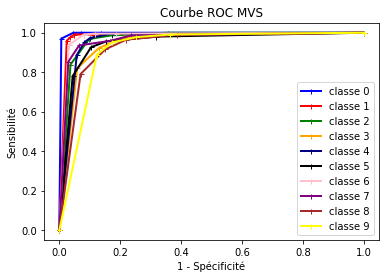

In [ ]:
# Calculation of the probability vector.
probabilities = model.predict_proba(Xtt)
for i in range(10):
  courbe_ROC(i, Ytt, probabilities, colors[i])
plt.title('Courbe ROC MVS')
plt.xlabel('1 - Spécificité')
plt.ylabel('Sensibilité')
plt.legend(loc="lower right")
plt.show()



*   **ROC curve with sklearn**



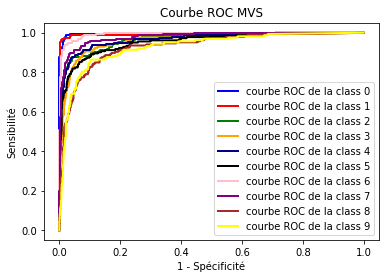

In [ ]:
# Import the modules (roc_curve, label_binarize, OneVsRestClassifier).
from sklearn.metrics import roc_curve
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier

# Binarize Ytt (labels).
Y_binaire = label_binarize(Y, classes=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
# numbre of classes
nbr_classes = np.unique(Y.shape[0])

Xt, Xtt, Yt, Ytt = train_test_split(X, Y_binaire, random_state=0, test_size=1/3)
model = OneVsRestClassifier(svm.SVC(kernel='linear', probability=True) )
model.fit(Xt, Yt)


Yttproba = model.predict_proba(Xtt)
fpr = dict()
tpr = dict()
# Calculate FPR (False Positive Rate), TPR (True Positive Rate).
for i in range(10):
  fpr[i], tpr[i],_ = roc_curve(Ytt[:, i], Yttproba[:, i])

colors = ['blue', 'red', 'green', 'orange', 'navy', 'black', 'pink', 'purple', 'brown', 'yellow']
for i in range(10):
    plt.plot(fpr[i], tpr[i], color=colors[i], linewidth=2, label='courbe ROC de la class {0}'.format(i))


# Plotting the ROC curve.
plt.title('Courbe ROC MVS')
plt.xlabel('1 - Spécificité')
plt.ylabel('Sensibilité')
plt.legend(loc="lower right")
plt.show()

# Method 2: Decision Trees

In [ ]:
Xt, Xtt, Yt, Ytt = train_test_split(X, Y, random_state=0, test_size=1/3)
# Create the model
model = DecisionTreeClassifier()
# train the model
model = model.fit(Xt, Yt)
# Prediction
y_pred = model.predict(Xtt)

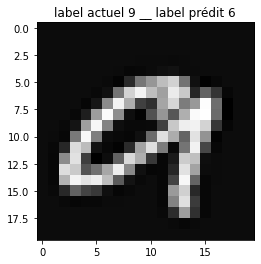

In [ ]:
# test for an image
c= 3
y_pred[c]
a = Xtt[c,:].reshape((20, 20))
a=np.transpose(a)
plt.title('label actuel '+ str(Ytt[c])+' __ label prédit '+ str(y_pred[c]))
plt.imshow(a,cmap='gray')

# Testing implemented functions for the Decision Tree algorithm and comparison with those from sklearn.



*   **Confusion Matrix**



In [ ]:
# calculation of the confusion matrix
matrice_confusion(Ytt,y_pred)

array([[136,   1,   0,   1,   1,   5,   1,   5,   1,   1],
       [  1, 148,   1,   0,   4,   2,   0,   4,   2,   2],
       [  2,   8, 115,   8,   3,   2,   2,   7,   9,   7],
       [  2,   3,   9, 120,   2,  10,   2,   6,  12,   4],
       [  1,   2,   9,   0, 119,   2,   7,   3,   5,   9],
       [  8,   4,   1,  10,   6, 133,   3,   5,  10,   2],
       [  2,   5,   1,   3,   3,  12, 127,   1,   3,   5],
       [  1,   2,   5,   9,   2,   1,   0, 139,   4,   6],
       [  2,   1,   9,  13,   3,   5,   7,   2, 129,  15],
       [  1,   3,   3,   6,  11,   1,   5,   8,   7, 117]], dtype=uint8)



*   **Confusion Matrix with sklearn**



In [ ]:
confusion_matrix(Ytt, y_pred)

array([[136,   1,   0,   1,   1,   5,   1,   5,   1,   1],
       [  1, 148,   1,   0,   4,   2,   0,   4,   2,   2],
       [  2,   8, 115,   8,   3,   2,   2,   7,   9,   7],
       [  2,   3,   9, 120,   2,  10,   2,   6,  12,   4],
       [  1,   2,   9,   0, 119,   2,   7,   3,   5,   9],
       [  8,   4,   1,  10,   6, 133,   3,   5,  10,   2],
       [  2,   5,   1,   3,   3,  12, 127,   1,   3,   5],
       [  1,   2,   5,   9,   2,   1,   0, 139,   4,   6],
       [  2,   1,   9,  13,   3,   5,   7,   2, 129,  15],
       [  1,   3,   3,   6,  11,   1,   5,   8,   7, 117]])

*   **FP, VP, VN, FN**

In [ ]:
# Calculate FP, TP, TN, FN values for all classes in Ytt.
for i in range(10):
  dictScratch  = valeurs_matrice_confusion(matrice_confusion(Ytt,y_pred), i)
  # print the results
  print("FP classe "+str(i)+" est : "+str(dictScratch["FP"]))
  print("VP classe "+str(i)+" est : "+str(dictScratch["VP"]))
  print("VN classe "+str(i)+" est : "+str(dictScratch["VN"]))
  print("FN classe "+str(i)+" est : "+str(dictScratch["FN"]))
  print("------------------------------------------------------------------------------------------------------")

FP classe 0 est : 20
VP classe 0 est : 136
VN classe 0 est : 1495
FN classe 0 est : 16
------------------------------------------------------------------------------------------------------
FP classe 1 est : 29
VP classe 1 est : 148
VN classe 1 est : 1474
FN classe 1 est : 16
------------------------------------------------------------------------------------------------------
FP classe 2 est : 38
VP classe 2 est : 115
VN classe 2 est : 1466
FN classe 2 est : 48
------------------------------------------------------------------------------------------------------
FP classe 3 est : 50
VP classe 3 est : 120
VN classe 3 est : 1447
FN classe 3 est : 50
------------------------------------------------------------------------------------------------------
FP classe 4 est : 35
VP classe 4 est : 119
VN classe 4 est : 1475
FN classe 4 est : 38
------------------------------------------------------------------------------------------------------
FP classe 5 est : 40
VP classe 5 est : 133
VN clas



*   **Recall**



In [ ]:
# Calculate the recall value for all classes in Ytt
for i in range(10):
  print("rappel classe "+str(i)+" = "+str(rappel(matrice_confusion(Ytt,y_pred), i)))
  print("------------------------------------------------------------------------------------------------------")

rappel classe 0 = 0.8947368421052632
------------------------------------------------------------------------------------------------------
rappel classe 1 = 0.9024390243902439
------------------------------------------------------------------------------------------------------
rappel classe 2 = 0.7055214723926381
------------------------------------------------------------------------------------------------------
rappel classe 3 = 0.7058823529411765
------------------------------------------------------------------------------------------------------
rappel classe 4 = 0.7579617834394905
------------------------------------------------------------------------------------------------------
rappel classe 5 = 0.7307692307692307
------------------------------------------------------------------------------------------------------
rappel classe 6 = 0.7839506172839507
------------------------------------------------------------------------------------------------------
rappel classe 7 = 0.



*   **Recall with sklearn**



In [ ]:
# Recall
from sklearn import metrics
print(metrics.recall_score(Ytt, y_pred, average=None))

[0.89473684 0.90243902 0.70552147 0.70588235 0.75796178 0.73076923
 0.78395062 0.82248521 0.69354839 0.72222222]




*   **precision**



In [ ]:
# Calculate the precision for all classes in Ytt.
for i in range(10):
  print("précision classe "+str(i)+" = "+str(precision(matrice_confusion(Ytt,y_pred), i)))
  print("------------------------------------------------------------------------------------------------------")

précision classe 0 = 0.8717948717948718
------------------------------------------------------------------------------------------------------
précision classe 1 = 0.8361581920903954
------------------------------------------------------------------------------------------------------
précision classe 2 = 0.7516339869281046
------------------------------------------------------------------------------------------------------
précision classe 3 = 0.7058823529411765
------------------------------------------------------------------------------------------------------
précision classe 4 = 0.7727272727272727
------------------------------------------------------------------------------------------------------
précision classe 5 = 0.7687861271676301
------------------------------------------------------------------------------------------------------
précision classe 6 = 0.8246753246753247
------------------------------------------------------------------------------------------------------



*   **precision with sklearn**



In [ ]:
# precision
print(metrics.precision_score(Ytt, y_pred, average=None))

[0.87179487 0.83615819 0.75163399 0.70588235 0.77272727 0.76878613
 0.82467532 0.77222222 0.70879121 0.69642857]




*   **False Positive Rate**



In [ ]:
# Calculate the false positive rate for all classes of Ytt.
for i in range(10):
  print("Taux de FP classe "+str(i)+" = "+str(Taux_FP(matrice_confusion(Ytt,y_pred), i)))
  print("------------------------------------------------------------------------------------------------------")

Taux de FP classe 0 = 0.1282051282051282
------------------------------------------------------------------------------------------------------
Taux de FP classe 1 = 0.1638418079096045
------------------------------------------------------------------------------------------------------
Taux de FP classe 2 = 0.24836601307189543
------------------------------------------------------------------------------------------------------
Taux de FP classe 3 = 0.29411764705882354
------------------------------------------------------------------------------------------------------
Taux de FP classe 4 = 0.22727272727272727
------------------------------------------------------------------------------------------------------
Taux de FP classe 5 = 0.23121387283236994
------------------------------------------------------------------------------------------------------
Taux de FP classe 6 = 0.17532467532467533
------------------------------------------------------------------------------------------



*   **specificity**



In [ ]:
# Calculate the specificity for all classes of Ytt.
for i in range(10):
  print("spécificité classe "+str(i)+" = "+str(specificite(matrice_confusion(Ytt,y_pred), i)))
  print("------------------------------------------------------------------------------------------------------")

spécificité classe 0 = 0.9867986798679867
------------------------------------------------------------------------------------------------------
spécificité classe 1 = 0.980705256154358
------------------------------------------------------------------------------------------------------
spécificité classe 2 = 0.9747340425531915
------------------------------------------------------------------------------------------------------
spécificité classe 3 = 0.9665998663994656
------------------------------------------------------------------------------------------------------
spécificité classe 4 = 0.9768211920529801
------------------------------------------------------------------------------------------------------
spécificité classe 5 = 0.9730639730639731
------------------------------------------------------------------------------------------------------
spécificité classe 6 = 0.9820598006644519
-----------------------------------------------------------------------------------------



*   **ROC curve**



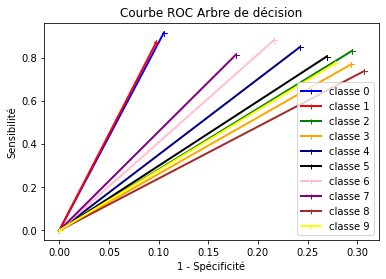

In [ ]:
# Calculation of the probability vector.
probabilities = model.predict_proba(Xtt)
for i in range(10):
  courbe_ROC(i, Ytt, probabilities, colors[i])
plt.title('Courbe ROC Arbre de décision')
plt.xlabel('1 - Spécificité')
plt.ylabel('Sensibilité')
plt.legend(loc="lower right")
plt.show()



*   **ROC curve with sklearn**



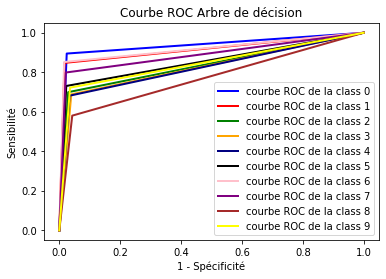

In [ ]:
#Import the modules (roc_curve, label_binarize, OneVsRestClassifier).
from sklearn.metrics import roc_curve
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier

# Binarize Ytt (labels).
Y_binaire = label_binarize(Y, classes=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
# numbre of classes
nbr_classes = np.unique(Y.shape[0])

Xt, Xtt, Yt, Ytt = train_test_split(X, Y_binaire, random_state=0, test_size=1/3)
model = OneVsRestClassifier(DecisionTreeClassifier())
model.fit(Xt, Yt)


Yttproba = model.predict_proba(Xtt)
fpr = dict()
tpr = dict()
# Calculate FPR, TPR
for i in range(10)
  fpr[i], tpr[i],_ = roc_curve(Ytt[:, i], Yttproba[:, i])

colors = ['blue', 'red', 'green', 'orange', 'navy', 'black', 'pink', 'purple', 'brown', 'yellow']
for i in range(10):
    plt.plot(fpr[i], tpr[i], color=colors[i], linewidth=2, label='courbe ROC de la class {0}'.format(i))


# Plot of the ROC curve.
plt.title('Courbe ROC Arbre de décision')
plt.xlabel('1 - Spécificité')
plt.ylabel('Sensibilité')
plt.legend(loc="lower right")
plt.show()

# Method 3: NN
Artificial Neural Networks (Perceptron)

In [ ]:
model = MLPClassifier(solver='sgd', alpha=1e-5, hidden_layer_sizes=(25),max_iter=100000)
Xt, Xtt, Yt, Ytt = train_test_split(X, Y, random_state=0, test_size=0.7)
model.fit(Xt, Yt)

MLPClassifier(alpha=1e-05, hidden_layer_sizes=25, max_iter=100000, solver='sgd')

In [ ]:
#Select a test image.
c=0

In [ ]:
model.predict([Xtt[c,:]])

array([5])

In [ ]:
# For ROC analysis, probabilities will be needed.
model.predict_proba([Xtt[c,:]])

array([[0.10814009, 0.09184036, 0.08598934, 0.10249758, 0.09330764,
        0.11275659, 0.10238214, 0.08904102, 0.10812383, 0.10592139]])

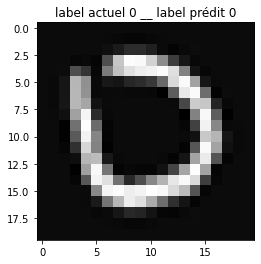

In [ ]:
# Display the tested image
a = Xtt[c,:].reshape((20, 20))
a=np.transpose(a)
plt.title('label actuel '+ str(Ytt[c])+' __ label prédit '+ str(y_pred[c]))
plt.imshow(a,cmap='gray')

#Testing the implemented functions for RN and comparison with those from sklearn.



*   **Confusion Matrix**



In [ ]:
y_pred = model.predict(Xtt)
# calculation of the confusion matrix
matrice_confusion(Ytt,y_pred)

array([[  0,   0,   0,   0,   0,  98,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,  95,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,  98,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0, 102,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,  82,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,  95,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,  87,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,  94,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,  94,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,  95,   0,   0,   0,   0]], dtype=uint8)



*   **Confusion Matrix with sklearn**



In [ ]:
confusion_matrix(Ytt, y_pred)

array([[  0,   0,   0,   0,   0, 354,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0, 351,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0, 354,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0, 358,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0, 338,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0, 351,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0, 343,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0, 350,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0, 350,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0, 351,   0,   0,   0,   0]])



*   **FP, VP, VN, FN**



In [ ]:
# Calculate the values of FP, TP, TN, and FN for all classes of Ytt.
for i in range(10):
  dictScratch  = valeurs_matrice_confusion(matrice_confusion(Ytt,y_pred), i)
  print("FP classe "+str(i)+" est : "+str(dictScratch["FP"]))
  print("VP classe "+str(i)+" est : "+str(dictScratch["VP"]))
  print("VN classe "+str(i)+" est : "+str(dictScratch["VN"]))
  print("FN classe "+str(i)+" est : "+str(dictScratch["FN"]))
  print("------------------------------------------------------------------------------------------------------")

FP classe 0 est : 0
VP classe 0 est : 0
VN classe 0 est : 842
FN classe 0 est : 98
------------------------------------------------------------------------------------------------------
FP classe 1 est : 0
VP classe 1 est : 0
VN classe 1 est : 845
FN classe 1 est : 95
------------------------------------------------------------------------------------------------------
FP classe 2 est : 0
VP classe 2 est : 0
VN classe 2 est : 842
FN classe 2 est : 98
------------------------------------------------------------------------------------------------------
FP classe 3 est : 0
VP classe 3 est : 0
VN classe 3 est : 838
FN classe 3 est : 102
------------------------------------------------------------------------------------------------------
FP classe 4 est : 0
VP classe 4 est : 0
VN classe 4 est : 858
FN classe 4 est : 82
------------------------------------------------------------------------------------------------------
FP classe 5 est : 845
VP classe 5 est : 95
VN classe 5 est : 0
FN cla



*   **Recall**



In [ ]:
#Calculate the recall value for all classes of Ytt.
for i in range(10):
  print("rappel classe "+str(i)+" = "+str(rappel(matrice_confusion(Ytt,y_pred), i)))
  print("------------------------------------------------------------------------------------------------------")

rappel classe 0 = 0.0
------------------------------------------------------------------------------------------------------
rappel classe 1 = 0.0
------------------------------------------------------------------------------------------------------
rappel classe 2 = 0.0
------------------------------------------------------------------------------------------------------
rappel classe 3 = 0.0
------------------------------------------------------------------------------------------------------
rappel classe 4 = 0.0
------------------------------------------------------------------------------------------------------
rappel classe 5 = 1.0
------------------------------------------------------------------------------------------------------
rappel classe 6 = 0.0
------------------------------------------------------------------------------------------------------
rappel classe 7 = 0.0
------------------------------------------------------------------------------------------------------




*   **Recall with sklearn**



In [ ]:
# Recall
from sklearn import metrics
print(metrics.recall_score(Ytt, y_pred, average=None))

[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]




*   **precision**



In [ ]:
# Calculate the precision for all classes of Ytt.
for i in range(10):
  print("précision classe "+str(i)+" = "+str(precision(matrice_confusion(Ytt,y_pred), i)))
  print("------------------------------------------------------------------------------------------------------")

précision classe 0 = nan
------------------------------------------------------------------------------------------------------
précision classe 1 = nan
------------------------------------------------------------------------------------------------------
précision classe 2 = nan
------------------------------------------------------------------------------------------------------
précision classe 3 = nan
------------------------------------------------------------------------------------------------------
précision classe 4 = nan
------------------------------------------------------------------------------------------------------
précision classe 5 = 0.10106382978723404
------------------------------------------------------------------------------------------------------
précision classe 6 = nan
------------------------------------------------------------------------------------------------------
précision classe 7 = nan
---------------------------------------------------------------

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in true_divide
  """




*   **precision with sklearn**



In [ ]:
# precision
print(metrics.precision_score(Ytt, y_pred, average=None))

[0.         0.         0.         0.         0.         0.10028571
 0.         0.         0.         0.        ]


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))




*   **False Positive Rate**



In [ ]:
# Calculate the False Positive Rate (FPR) for all classes of Ytt.
for i in range(10):
  print("Taux de FP classe "+str(i)+" = "+str(Taux_FP(matrice_confusion(Ytt,y_pred), i)))
  print("------------------------------------------------------------------------------------------------------")

Taux de FP classe 0 = nan
------------------------------------------------------------------------------------------------------
Taux de FP classe 1 = nan
------------------------------------------------------------------------------------------------------


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in ulong_scalars
  """


Taux de FP classe 2 = nan
------------------------------------------------------------------------------------------------------
Taux de FP classe 3 = nan
------------------------------------------------------------------------------------------------------
Taux de FP classe 4 = nan
------------------------------------------------------------------------------------------------------
Taux de FP classe 5 = 0.898936170212766
------------------------------------------------------------------------------------------------------
Taux de FP classe 6 = nan
------------------------------------------------------------------------------------------------------
Taux de FP classe 7 = nan
------------------------------------------------------------------------------------------------------
Taux de FP classe 8 = nan
------------------------------------------------------------------------------------------------------
Taux de FP classe 9 = nan
---------------------------------------------------------



*   **specificity**



In [ ]:
# Calculate the specificity for all classes of Ytt.
for i in range(10):
  print("spécificité classe "+str(i)+" = "+str(specificite(matrice_confusion(Ytt,y_pred), i)))
  print("------------------------------------------------------------------------------------------------------")

spécificité classe 0 = 1.0
------------------------------------------------------------------------------------------------------
spécificité classe 1 = 1.0
------------------------------------------------------------------------------------------------------
spécificité classe 2 = 1.0
------------------------------------------------------------------------------------------------------
spécificité classe 3 = 1.0
------------------------------------------------------------------------------------------------------
spécificité classe 4 = 1.0
------------------------------------------------------------------------------------------------------
spécificité classe 5 = 0.0
------------------------------------------------------------------------------------------------------
spécificité classe 6 = 1.0
------------------------------------------------------------------------------------------------------
spécificité classe 7 = 1.0
---------------------------------------------------------------



*   **ROC curve**



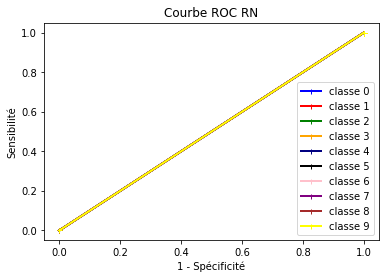

In [ ]:
# Calculation of the probability vector.
probabilities = model.predict_proba(Xtt)
for i in range(10):
  courbe_ROC(i, Ytt, probabilities, colors[i])
plt.title('Courbe ROC RN')
plt.xlabel('1 - Spécificité')
plt.ylabel('Sensibilité')
plt.legend(loc="lower right")
plt.show()



*   **ROC curve with sklearn**



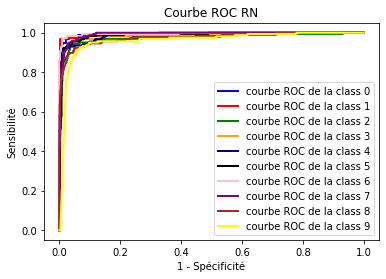

In [ ]:
# Import the modules (roc_curve, label_binarize, OneVsRestClassifier).
from sklearn.metrics import roc_curve
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier

# Binarize Ytt (labels).
Y_binaire = label_binarize(Y, classes=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
# numbre of classes
nbr_classes = np.unique(Y.shape[0])

Xt, Xtt, Yt, Ytt = train_test_split(X, Y_binaire, random_state=0, test_size=1/3)
model = OneVsRestClassifier(MLPClassifier(solver='sgd', alpha=1e-5, hidden_layer_sizes=(25),max_iter=100000))
model.fit(Xt, Yt)


Yttproba = model.predict_proba(Xtt)
fpr = dict()
tpr = dict()
# Calculation of FPR (False Positive Rate) and TPR (True Positive Rate).
for i in range(10):
  fpr[i], tpr[i],_ = roc_curve(Ytt[:, i], Yttproba[:, i])

colors = ['blue', 'red', 'green', 'orange', 'navy', 'black', 'pink', 'purple', 'brown', 'yellow']
for i in range(10):
    plt.plot(fpr[i], tpr[i], color=colors[i], linewidth=2, label='courbe ROC de la class {0}'.format(i))


# Plotting the ROC curve.
plt.title('Courbe ROC RN')
plt.xlabel('1 - Spécificité')
plt.ylabel('Sensibilité')
plt.legend(loc="lower right")
plt.show()

# Méthode 4: CNN
Convolutional Neural Networks (CNNs).

In [ ]:
# reshape dataset to have a single channel
Xt, Xtt, Yt, Ytt = train_test_split(X, Y, random_state=0, test_size=0.7)

Xt_rnc = Xt.reshape((Xt.shape[0], 20, 20, 1))
Xtt_rnc = Xtt.reshape((Xtt.shape[0], 20, 20, 1))

In [ ]:
# Recode the values
Yt_rnc = to_categorical(Yt)
Ytt_rnc = to_categorical(Ytt)

Xt_rncN = Xt_rnc.astype('float32')
Xtt_rncN = Xtt_rnc.astype('float32')

# Normalize
Xt_rncN = Xt_rncN / 255.0
Xtt_rncN = Xtt_rncN / 255.0

# Define the CNN model
model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', input_shape=(20, 20, 1)))
model.add(MaxPooling2D((2, 2)))
model.add(Flatten())
model.add(Dense(100, activation='relu', kernel_initializer='he_uniform'))
model.add(Dense(10, activation='softmax'))
# compiler the model
opt = SGD(learning_rate=0.01, momentum=0.9)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

# evaluate the model
_, acc = model.evaluate(Xtt_rncN, Ytt_rnc, verbose=0)